<a href="https://colab.research.google.com/github/aborundiya/NeuralNetwork/blob/master/GenericNeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import all required libraries

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.colors
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, mean_squared_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs,make_moons, make_circles
from tqdm import tqdm_notebook 
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("",["red","yellow","green"])
np.random.seed(0)

#Generating data sets through make_blobs

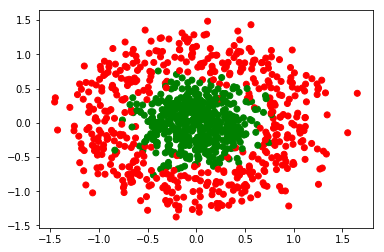

In [91]:
#data , labels = make_blobs(n_samples = 1000, n_features = 2 , centers = 4, random_state =0 )
#data , labels = make_moons(n_samples =1000, random_state=0, noise =0.15)
data , labels = make_circles(n_samples =1000, random_state=0, noise =0.2, factor = 0.3)
plt.scatter(data[:,0], data[:,1], c=labels, cmap = my_cmap)
plt.show()

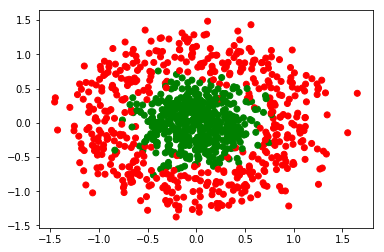

In [92]:
labels_original = labels
labels = np.mod(labels_original,2)
plt.scatter(data[:,0],data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(data,labels,stratify = labels, random_state =0 )

#Generic Feed Forward Neural Network Class  for Single Output

In [0]:
class GenericFFNN():
  
  def __init__(self, n_inputs, hidden_sizes= [2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self,x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_sigmoid(self, x):
    return x * (1 - x)
  
  def forward_pass(self,x):
    self.A ={}
    self.H ={}
    self.H[0]=x.reshape(1,-1)
    for i in range(self.nh + 1 ):
      self.A[i+1] = np.matmul(self.H[i],self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i +1 ])
    return self.H[self.nh + 1 ]
  
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))
  
  def fit(self, X, Y, epochs = 1 , learning_rate = 1 , initialise = True, display_loss = False ):
    
    #initialise 
    if initialise :
      for i in range(self.nh + 1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    if display_loss:
      loss = {}
    
    for e in tqdm_notebook(range(epochs), total = epochs , unit = "epoch"):
      dW ={}
      dB ={}
      for i in range(self.nh + 1):
        dW[i+1] = np.zeros((self.sizes[i],self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X,Y):
        self.grad(x,y)
        for i in range(self.nh + 1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
          
      m = X.shape[1]
      for i in range(self.nh +1): 
        self.W[i+1] -= learning_rate * dW[i+1]/m
        self.B[i+1] -= learning_rate * dB[i+1]/m
      
      if display_loss:
        y_pred = self.predict(X)
        loss[e]= mean_squared_error(y_pred,Y)
        
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel("Epoch")
      plt.ylabel("mean Squared Error")
      plt.show()
      
  
  def predict(self,X):
    Y_pred = []
    for x in X:
      pred = self.forward_pass(x)
      Y_pred.append(pred)
    return np.array(Y_pred).squeeze()

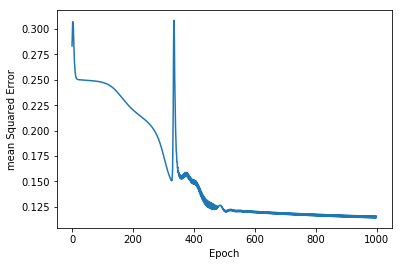

In [105]:
ffsnn = GenericFFNN(2,[2,4])
ffsnn.fit(X_train, Y_train, epochs=1000, learning_rate=.01, display_loss=True)

In [106]:
Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >=0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >=0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_test = accuracy_score(Y_pred_binarised_val, Y_val)
print("Training Accuracy", round(accuracy_train,2))
print("Testing Accuracy", round(accuracy_test,2))

Training Accuracy 0.83
Testing Accuracy 0.87


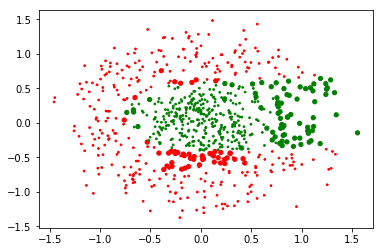

In [107]:
plt.scatter(X_train[:,0],X_train[:,1],c=Y_pred_binarised_train, cmap =my_cmap, s = 15 * (np.abs(Y_pred_binarised_train-Y_train)+0.2))
plt.show()